In [8]:
import numpy as np
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
class PDE:
    def __init__(self, xi, 
                 tpoints=201, xpoints=512, 
                 trange=(0,20), xrange=(-30, 30), 
                 boundary='periodic', 
                 seed=0):
        """
        xi is a 2d matrix where each entry corresponds to a coefficient of a term, 
        where the 1st axis corresponds to the order of the space partial derivative
        and the 2nd axis corresponds to the degree of the function.
        For example, ut = 1+2u+3u**2 + 4ux+5uxu+6uxu**2 + 7uxx+8uxxu+9uxxu**2
        becomes [[1, 2, 3],[4, 5, 6],[7, 8, 9]]
        
        neumann boundary: derivatives at ends are null
        """
        
        self.rng = np.random.RandomState(seed)
        self.boundary = boundary
        
        self.xi = xi
        self.max_order = self.xi.shape[0]-1 #the minus 1 is because it goes from 0 to max, inclusive
        self.max_degree = self.xi.shape[1]-1 #the minus 1 is because it goes from 0 to max, inclusive
        
        self.tpoints = tpoints
        self.xpoints = xpoints
        self.trange = trange
        self.xrange = xrange
        
        self.dt = (self.trange[1]-self.trange[0])/ self.tpoints #time steps
        self.dx = (self.xrange[1]-self.xrange[0])/ self.xpoints #space step
        
        self.u = self.init_u()
        self.simulated = False
        
    def init_u(self):
        #makes one wavelength of cos, from 1 crest to the next
        xarr = np.linspace(self.xrange[0], self.xrange[1], self.xpoints, endpoint=False)
        k = 2*np.pi/(self.xrange[1] - self.xrange[0])
        phi = np.pi
        u0 = np.cos(k*xarr+phi)
        uempty = np.full((self.xpoints,), np.nan, dtype=float)
        return np.vstack([u0]+[uempty]*(self.tpoints-1))
    
    def __str__(self):
        string = 'ut ='
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                if coef == 0:
                    term = ''
                else:
                    #coefficient factor
                    if coef > 0:
                        term = ' + ' + str(coef)
                    elif coef < 0:
                        term = ' - ' + str(-coef)
                    #partial deriv factor
                    if order > 0:
                        term += 'u' + 'x'*order
                    else: 
                        pass
                    #function factor
                    if degree == 1:
                        term += 'u'
                    elif degree > 1:
                        term += 'u**'+degree
                    else: 
                        pass
                string += term
        if string == 'ut =':
            rep = 'ut = 0'
        return string
    def __repr__(self):
        rep = self.__str__()
        rep += '\n\twith xpoints='+str(self.xpoints)+' in '+str(self.xrange)
        rep += '\n\tand with tpoints='+str(self.tpoints)+' in '+str(self.trange)
        rep += '\n\twith '+str(self.boundary)+' boundary condition'
        return rep
        
    def get_dgrid_x(self, grid, point):
        try:
            right = grid[point+1]
        except IndexError:
            if self.boundary=='periodic':
                pright = grid[point+1-self.xpoints]
            else:
                raise
        try:
            left = grid[point]
        except IndexError:
            if self.boundary=='periodic':
                left = grid[point-self.xpoints]
            else:
                raise
        return right - left
    def get_dgrid_x_middle(self, grid, point):
        try:
            right = grid[point+1]
        except IndexError:
            if self.boundary=='periodic':
                pright = grid[point+1-self.xpoints]
            else:
                raise
        try:
            left = grid[point-1]
        except IndexError:
            if self.boundary=='periodic':
                left = grid[point-1-self.xpoints]
            else:
                raise
        return right - left
    def get_du_x(self, time, point):
        return self.get_dgrid_x(self.u[time], point)
    def get_du_x_middle(self, grid, point):
        return self.get_dgrid_x_middle(self.u[time], point)
    
    def get_x_deriv_forward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point)
        else:
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point, order-1))/self.dx
    def get_x_deriv_backward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point-1)
        else:
            return (self.get_x_deriv(time, point, order-1)-self.get_x_deriv(time, point-1, order-1))/self.dx
    def get_x_deriv_middle(self, time, point, order):
        if order == 0:
            return self.get_du_x_middle(time, point)/(2*self.dx)
        else: 
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point-1, order-1))/(2*self.dx)
    def get_x_deriv(self, time, point, order):
        if order > 0:
            try:
                deriv = self.get_x_deriv_middle(time, point, order)
            except IndexError: #Only raised if not periodic
                try:
                    deriv = self.get_x_deriv_forward(time, point, order)
                except IndexError: #Only raised if not periodic
                    deriv = self.get_x_deriv_backward(time, point, order)
        elif order == 0:
            deriv = self.u[time, point]
        else:
            raise ValueError("Derivative order cannot be negative")
        return deriv
    def derive_grid_x(self, grid):
        deriv = np.empty_like(grid) 
        for point in range(self.xpoints):
            try:
                deriv[point] = self.get_dgrid_x_middle(grid, point) / (2*self.dx)
            except IndexError: #Only raised if not periodic
                try:
                    deriv[point] = self.get_dgrid_x(grid, point) / self.dx
                except IndexError: #Only raised if not periodic
                    deriv[point] = self.get_dgrid_x(grid, point-1) / self.dx
        return deriv
    def derive_grids_x(self, ugrid, xpoints, xrange, max_order=0, boundary='periodic', smoothing=True, deg=10, fact=0.01):
        """
        Parameters for smoothing:
            deg: controls the degree of the fitted polynomial
            fact (when positive): controls how much to look ahead and behind the defined interval, when the interval is periodic
            fact (when negative): controls how much to ignore from the ends of the interval, when the interval is not periodic
            fact should not be larger than +-half, 
                as that would make the fit take into account more than twice the number of points necessary (when positive),
                or it would ignore all points (when negative)
        """
        #preparation
        if max_order < 0:
            raise ValueError("Derivative order cannot be negative")
        derivs = np.empty((max_order+1, xpoints))
        derivs[0] = ugrid
        
        #smoothing
        if smoothing==True:
            assert abs(fact) <= 0.5, "Extra should not be more than half the number of points"
            extra = int(math.ceil(abs(self.xpoints*fact)))
            if max_order > 0:
                if boundary=='periodic':
                    assert fact < 0, "fact should be negative for periodic boundary conditions"
                    #creating array of x values
                    rangesize = xrange[1]-xrange[0]
                    xarrmid = np.linspace(xrange[0]-rangezise, xrange[1]+rangesize, 3*xpoints, endpoint=False)
                    xarr = xarrmid[xpoints-extra:extra-xpoints]
                    #creating array of u values
                    uarr = np.hstack([ugrid[time, -extra:], ugrid, ugrid[:extra]])
                else:
                    #creating array of x values
                    xarrmid = np.linspace(xrange[0], xrange[1], xpoints, endpoint=False)
                    xarr = xarrmid[extra:-extra]
                    #creating array of u values
                    uarr = ugrid[extra:-extra]
                #fitting polynomial
                poly = np.polynomial.chebyshev.Chebyshev.fit(xarr, uarr, deg)
                for order in range(1, max_order+1):
                    deriv = poly.deriv(order)
                    derivs[order] = deriv(xarrmid)
                    
        #no smoothing
        else:
            for order in range(1, max_order+1):
                derivs[order] = self.derive_grid_x(derivs[order-1])
                
        return derivs
    '''def get_x_derivs_grid(self, time, smoothing=True, deg=5, fact=0.01):
        """
        Parameters for smoothing:
            deg: controls the degree of the fitted polynomial
            fact (when positive): controls how much to look ahead and behind the defined interval, when the interval is periodic
            fact (when negative): controls how much to ignore from the ends of the interval, when the interval is not periodic
            fact should not be larger than +-half, 
                as that would make the fit take into account more than twice the number of points necessary (when positive),
                or it would ignore all points (when negative)
        """
        #preparation
        if self.max_order < 0:
            raise ValueError("Derivative order cannot be negative")
        derivs = np.empty((self.max_order+1, self.xpoints))
        derivs[0] = self.u[time]
        
        #smoothing
        if smoothing==True:
            assert abs(fact) <= 0.5, "Extra should not be more than half the number of points"
            extra = int(math.ceil(abs(self.xpoints*fact)))
            if self.max_order > 0:
                if self.boundary=='periodic':
                    assert fact < 0, "fact should be negative for periodic boundary conditions"
                    #creating array of x values
                    rangesize = self.xrange[1]-self.xrange[0]
                    xarrmid = np.linspace(self.xrange[0]-rangezise, self.xrange[1]+rangesize, 3*self.xpoints, endpoint=False)
                    xarr = xarrmid[self.xpoints-extra:extra-self.xpoints]
                    #creating array of u values
                    uarr = np.hstack([self.u[time, -extra:], self.u[time], self.u[time, :extra]])
                else:
                    #creating array of x values
                    xarrmid = np.linspace(self.xrange[0], self.xrange[1], self.xpoints, endpoint=False)
                    xarr = xarrmid[extra:-extra]
                    #creating array of u values
                    uarr = self.u[time, extra:-extra]
                #fitting polynomial
                poly = np.polynomial.chebyshev.Chebyshev.fit(xarr, uarr, deg)
                for order in range(1, self.max_order+1):
                    deriv = poly.deriv(order)
                    derivs[order] = deriv(xarrmid)
                    
        #no smoothing
        else:
            for order in range(1, self.max_order+1):
                derivs[order] = self.derive_grid_x(derivs[order-1])
                
        return derivs'''
    def get_x_derivs_grid(self, time, smoothing=True, deg=10, fact=0.01):
        return self.derive_grids_x(ugrid=self.u[time], 
                              xpoints=self.xpoints, xrange=self.xrange,
                              max_order=self.max_order, 
                              boundary=self.boundary, 
                              smoothing=smoothing, deg=deg, fact=fact)
    def get_t_deriv(self, time, point):
        deriv = 0
        for order in range(0, self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                u = self.u[time, point]
                if order == 0:
                    xderiv = 1
                else:
                    xderiv = self.get_x_deriv(time, point, order)
                try: 
                    deriv += coef * u**degree * xderiv
                except FloatingPointError:
                    raise
        return deriv
    def get_t_deriv_grid(self, time, smoothing=True, deg=10, fact=0.1):
        t_deriv_grid = np.zeros((self.xpoints,))
        for order in range(0, self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                u_grid = self.u[time]
                x_derivs_grid = self.get_x_derivs_grid(time, smoothing=smoothing, deg=deg, fact=fact)
                if order == 0:
                    x_deriv_grid = np.ones((self.xpoints,))
                else:
                    x_deriv_grid = x_derivs_grid[order]
                try: t_deriv_grid += coef * u_grid**degree * x_deriv_grid
                except FloatingPointError:
                    raise
        return t_deriv_grid
    
    def sim_next_point(self, time, point):
        u_curr = self.u[time, point]
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                u_next = u_curr + self.dt*self.get_t_deriv(time, point)
        if self.boundary == 'neumann':
            if point==0:
                u_next = self.sim_next_point(time, point+1)
            if point == self.xpoints-1:
                u_next = self.sim_next_point(time, point-1)
        return u_next
    def sim_next_grid(self, time, smoothing=True):
        u_next_grid = self.u[time] + self.get_t_deriv_grid(time, smoothing=smoothing) * self.dt
        if self.boundary == 'neumann':
            u_next_grid[0] = u_next_grid[1]
            u_next_grid[-1] = u_next_grid[-2]
        return u_next_grid
    def sim(self, smoothing=True, force=False):
        if self.simulated == False or force == True:
            if force == True: print("Resimulating PDE from initial conditions")
            for time in range(self.tpoints-1):
                self.u[time+1] = self.sim_next_grid(time, smoothing=smoothing)
            self.simulated == True
            return self.u
        else:
            print("PDE already simulated")
            return self.u

In [33]:
#xi = np.zeros((4, 2))
#xi[3,0] = -1
#xi[1,1] = 6
xi = np.zeros((3, 1))
xi[2, 0] = 1
pde = PDE(xi, xrange=(-np.pi, np.pi), boundary='neumann')
pde

ut = + 1.0uxx
	with xpoints=512 in (-3.141592653589793, 3.141592653589793)
	and with tpoints=201 in (0, 20)
	with neumann boundary condition

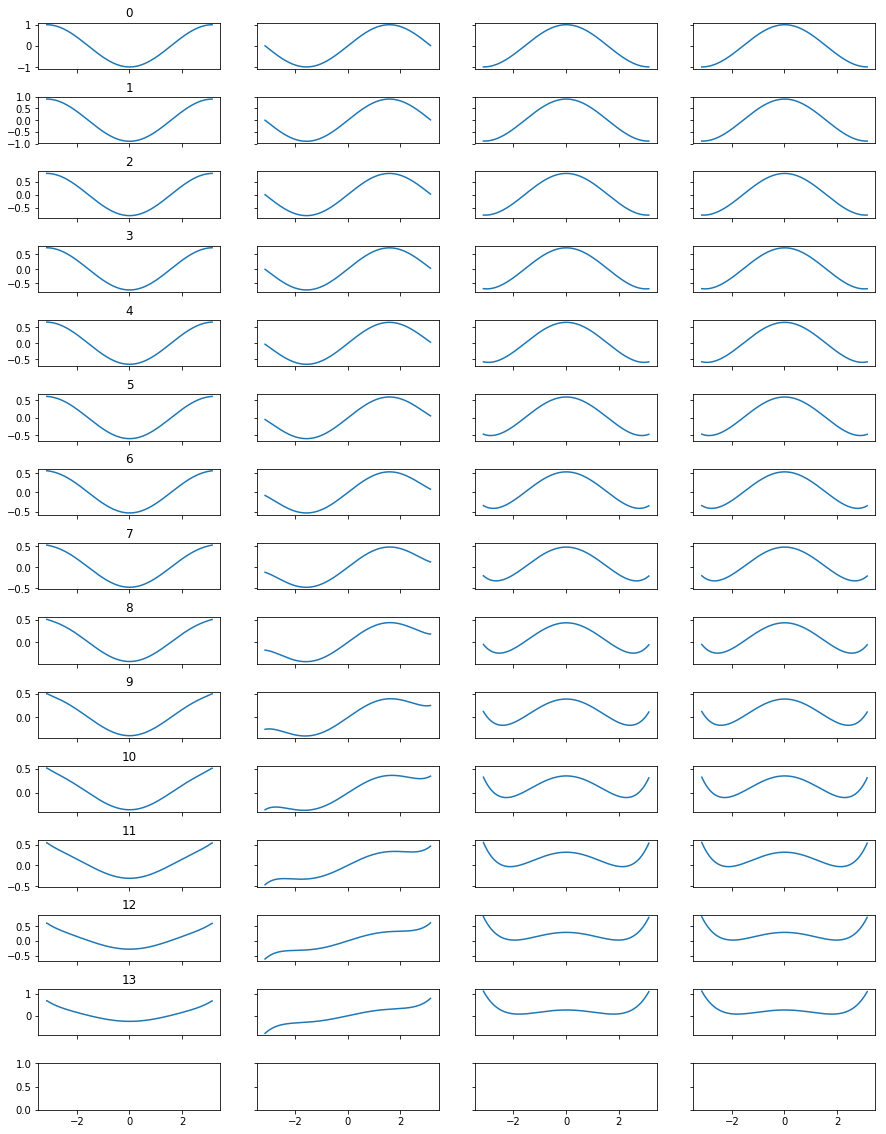

In [34]:
max_time = 14 #or pde.tpoints
jump_fact = 1
show_rough=False
show_smooth=True

fig, axes = plt.subplots(nrows=max_time//jump_fact+1, ncols=1+pde.max_order+1, figsize=(15,20), sharex=True, sharey='row')
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    if time % jump_fact == 0:
        if show_rough: rough_derivs = pde.get_x_derivs_grid(time, smoothing=False)
        if show_smooth: smooth_derivs = pde.get_x_derivs_grid(time, smoothing=True, deg=10, fact=0.01)
        for order in range(0, pde.max_order+1):
            if show_rough: yi_1 = rough_derivs[order]
            if show_smooth: yi_2 = smooth_derivs[order]
            if show_rough: axes[time//jump_fact, order].plot(x, yi_1)
            if show_smooth: axes[time//jump_fact, order].plot(x, yi_2)
        if show_rough: yn_1 = pde.get_t_deriv_grid(time, smoothing=False)
        if show_smooth: yn_2 = pde.get_t_deriv_grid(time, smoothing=True, deg=10, fact=0.01)
        if show_rough: axes[time//jump_fact, -1].plot(x, yn_1)
        if show_smooth: axes[time//jump_fact, -1].plot(x, yn_2)
        axes[time//jump_fact, 0].set_title(str(time))
        
        
    #ylim = axes[time//jump_fact, 0].get_ylim()
    #axes[time//jump_fact, -1].set_ylim(-1, 1)
        
    if time != max_time-1:
        pde.u[time+1] = pde.sim_next_grid(time, smoothing=True)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

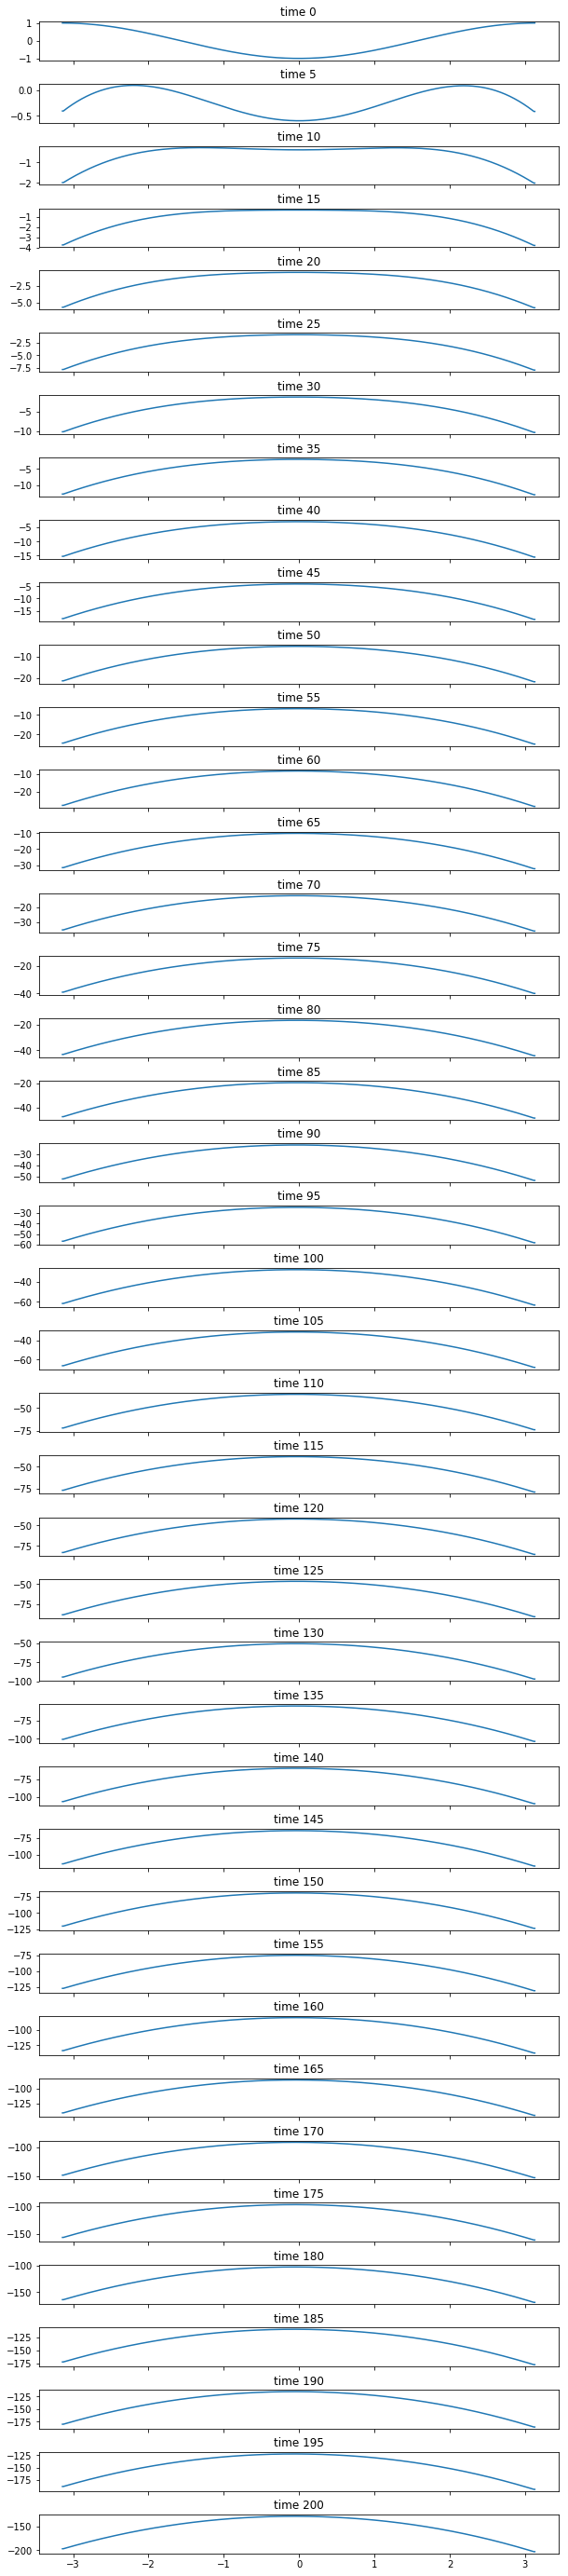

In [13]:
np.seterr(all='raise')
np.seterr(under='ignore')

max_time = pde.tpoints
jump_fact = 5

fig, axes = plt.subplots(nrows=max_time//jump_fact+1, figsize=(10,50), sharex=True, sharey=False)
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints, endpoint=False)

for time in range(max_time):
    #print(str(time)+": u = "+str(pde.u[time, 0]))
    if time % jump_fact == 0:
        y = pde.u[time]
        axes[time//jump_fact].plot(x, y)
        axes[time//jump_fact].set(title='time '+str(time))
    if time != max_time-1:
        pde.u[time+1] = pde.sim_next_grid(time)
axes[0].set_ylim(-1.1, 1.1)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

In [4]:
class PDE-FIND:
    
    def build_theta(pde, max_order=3, max_degree=5):
        pde.sim()
        theta = np.ones(pde.xpoints*pde.tpoints, (max_degree+1)*(max_order+1))
        
        #Make columns of values of u and derivatives at all spacetime points
        for t in range(tpoints):
            u_derivs_pde = pde.derive_grids_x(ugrid, xpoints, xrange, max_order=0, boundary='periodic', smoothing=True, deg=10, fact=0.01)

SyntaxError: invalid syntax (<ipython-input-4-91ff7b96dac5>, line 1)

### To Do
- rewrite get_x_deriv and it's forward/backward/middle versions to have less nested steps
- expand possible equations to include more non-linearity, like ut = sin(ux)
- make it possible to have an irregular grid spacing
- add other boundary conditions
- vectorize grid functions
- check why harmonic oscillator doesn't conserve energy
- make the sign of parameter fact when getting smooth derivative define whether to take more points or less when periodic
- use runge-kutta

### Notes
- Polynomial smoothing does not need to discard endpoints due to the periodic boundary conditions